In [16]:
import sys
import pybind11

sys.path.append("./build/")   # add build/ to Python module search path
import simulator
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.optimize import curve_fit

In [5]:
"""
py::arg("rows"),
py::arg("cols"),
py::arg("state") = "RANDOM",
py::arg("K") = 1,
py::arg("k_BT") = 5,
py::arg("h") = 0,
py::arg("seed") = time(0),
py::arg("file_name") = "output.txt
"""
sim = simulator.MCIsing(10, 10, state="UP", seed=42, file_name="test.txt", h=0, k_BT=5)

In [6]:
sim.initialize(state="UP")
sim_history = sim.run_numpy_output(500)

In [7]:
energy = sim.get_energy_record()
magnetization = sim.get_magnetization_record()

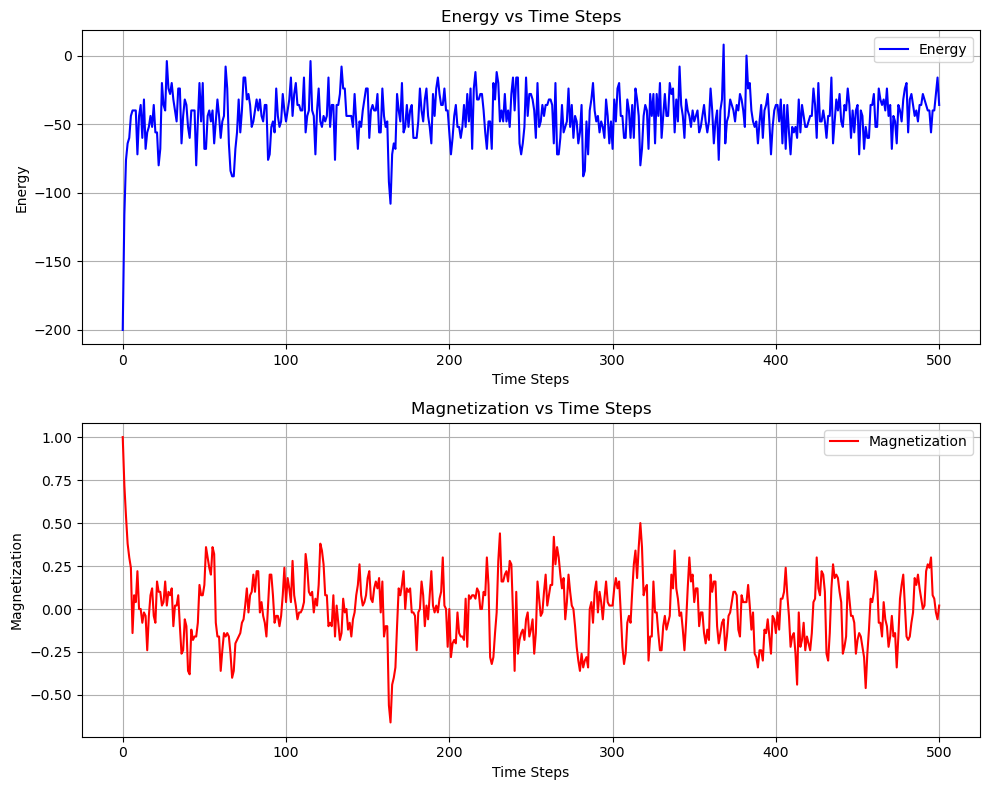

In [8]:
# Ploting the results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
ax1.plot(energy, label='Energy', color='blue')
ax1.set_title('Energy vs Time Steps')
ax1.set_xlabel('Time Steps')
ax1.set_ylabel('Energy')
ax1.legend()
ax1.grid()
ax2.plot(magnetization, label='Magnetization', color='red')
ax2.set_title('Magnetization vs Time Steps')
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('Magnetization')
ax2.legend()
ax2.grid()
plt.tight_layout()
plt.show()


In [9]:
magnetization[0]

1.0

In [15]:
sim_history[0]

array([[ 1,  1,  1,  1, -1,  1,  1,  1,  1,  1],
       [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
       [ 1,  1,  1,  1,  1, -1,  1, -1, -1,  1],
       [ 1,  1,  1,  1,  1, -1,  1, -1,  1,  1],
       [ 1, -1, -1,  1,  1,  1,  1,  1,  1,  1],
       [ 1,  1, -1, -1,  1,  1,  1,  1,  1,  1],
       [ 1,  1, -1,  1,  1,  1,  1,  1, -1,  1],
       [ 1,  1,  1,  1,  1,  1, -1,  1,  1, -1],
       [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
       [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1]], dtype=int32)

In [ ]:
def exp(x, a, b, c):
    return a*np.exp(-x/b) + c

popt_e, pcov_e = curve_fit(exp, np.arange(len(energy)), energy, p0=(1, 0.5, 1))
perr_e = np.sqrt(np.diag(pcov_e))

popt_m, pcov_m = curve_fit(exp, np.arange(len(magnetization)), magnetization, p0=(1, 0.5, 1))
perr_m = np.sqrt(np.diag(pcov_m))

print("Monte Carlo correlation time τ based on energy:", popt_e[1], "+-", perr_e[1])
print("Monte Carlo correlation time τ based on magnetization:", popt_m[1], "+-", perr_m[1])

Monte Carlo correlation time τ based on energy: 1.3620247195548099 +- 0.26282833965482627
Monte Carlo correlation time τ based on magnetization: 2.878167019588498 +- 0.702357081298808


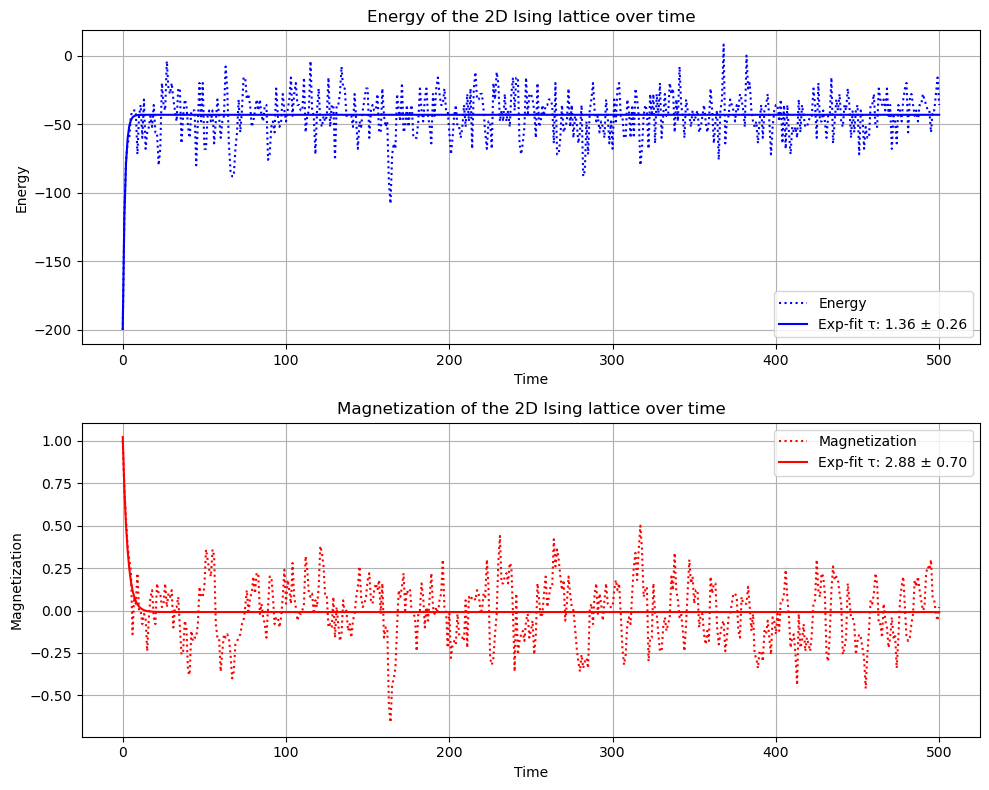

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
ax1.plot(energy, label='Energy', color='blue', ls=":")
ax1.plot(exp(np.arange(len(energy)), *popt_e), label=f"Exp-fit τ: {popt_e[1]:.2f} ± {perr_e[1]:.2f}", color='blue', ls="-")
ax1.set_title('Energy of the 2D Ising lattice over time')
ax1.set_xlabel('Time')
ax1.set_ylabel('Energy')
ax1.legend()
ax1.grid()
ax2.plot(magnetization, label='Magnetization', color='red', ls=":")
ax2.plot(exp(np.arange(len(magnetization)), *popt_m), label=f"Exp-fit τ: {popt_m[1]:.2f} ± {perr_m[1]:.2f}", color='red', ls="-")
ax2.set_title('Magnetization of the 2D Ising lattice over time')
ax2.set_xlabel('Time')
ax2.set_ylabel('Magnetization')
ax2.legend()
ax2.grid()
plt.tight_layout()
plt.show()